In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side

In [21]:
nb_cells = 3
r_in = 1
r_out = 2

In [22]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

In [23]:
organo = generate_ring(nb_cells, r_in, r_out)
Nf= organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
organo.edge_df.loc[:nb_cells, 'line_tension'] *= 2
organo.edge_df.loc[nb_cells:2*nb_cells, 'line_tension'] = 0
organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(np.pi/12) -
                                  organo.vert_df.y.copy() * np.sin(np.pi/12))
organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(np.pi/12) +
                                  organo.vert_df.y.copy() * np.cos(np.pi/12))
normalize_scale(organo, geom, refer='edges')
geom.update_all(organo)


Reseting datasets values with new specs


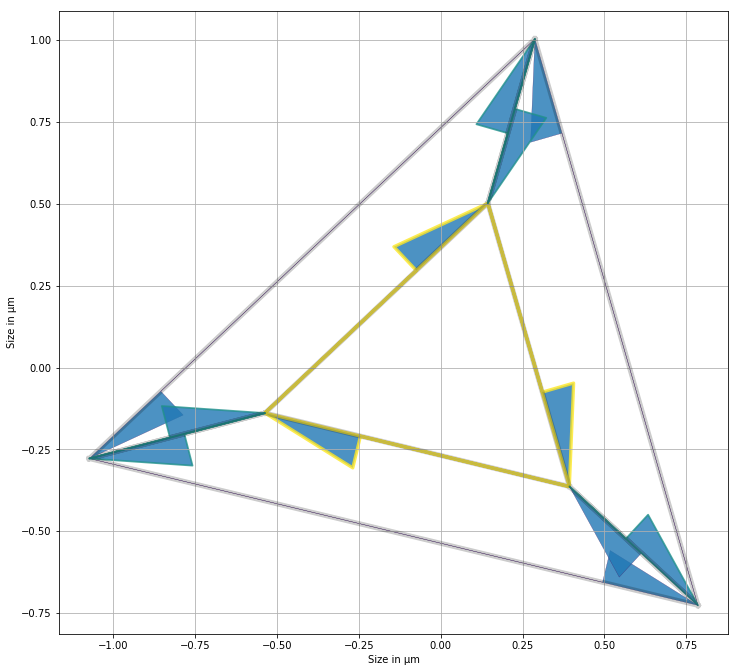

In [24]:
print_tensions(organo, organo)

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.2937701   0.         -0.61435908
   0.0641178 ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.          0.04266269  0.39007056  0.
  -0.08654665]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

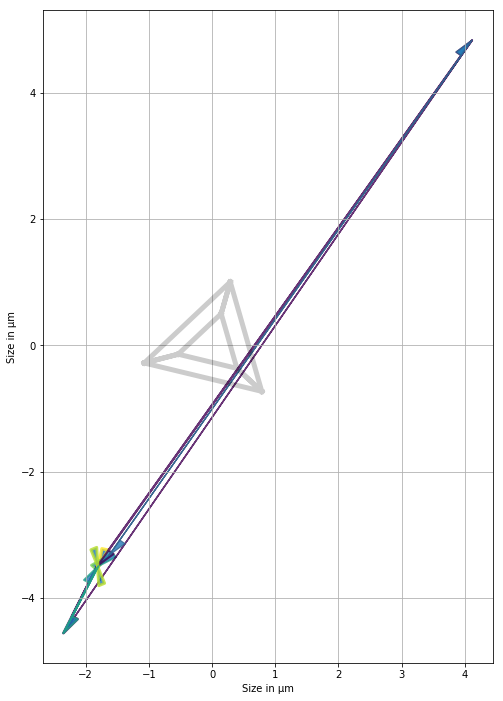

In [25]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='LINALG',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, fi_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                fi_sym_organo.edge_df.line_tension[:3*nb_cells]))))

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.2937701   0.         -0.61435908
   0.0641178 ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.          0.04266269  0.39007056  0.
  -0.08654665]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

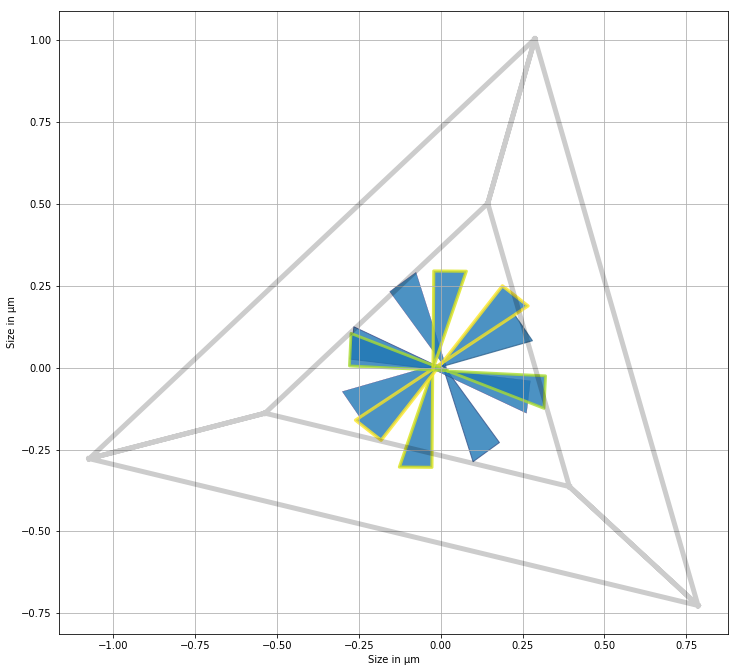

In [26]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.        ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.        ]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522]
 [ 0.          0.          0.         -0.97212617  0.         -0.2766769
  -0.73439456  0.          0.

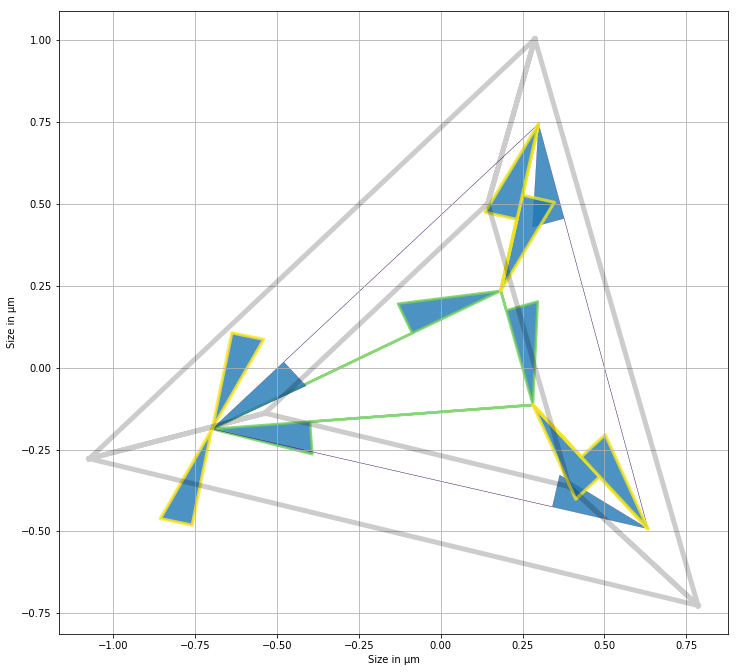

In [27]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, '')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

In [31]:
seed = 1553
def create_sym_organo(seed, nb_cells, r_in, r_out):
    sym_organo = generate_ring(nb_cells, r_in, r_out)
    Nf= sym_organo.Nf
    geom.update_all(sym_organo)
    #alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
    alpha = 1 + 1/(20*(sym_organo.settings['R_out']-sym_organo.settings['R_in']))


    # Model parameters or specifications
    specs = {
        'face':{
            'is_alive': 1,
            'prefered_area':  alpha*sym_organo.face_df.area, 
            'area_elasticity': 1.,},
        'edge':{        
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert':{
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': sym_organo.settings['lumen_volume'],
            'lumen_volume': sym_organo.settings['lumen_volume']
            }
        }

    sym_organo.update_specs(specs, reset=True)
    normalize_scale(sym_organo, geom, refer='edges')
    geom.update_all(sym_organo)

    symetric_tensions = 10*set_init_point(sym_organo.settings['R_in'], sym_organo.settings['R_out'], sym_organo.Nf, alpha)
    sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, sym_organo.Nf, endpoint=False)))**2
    sym_organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, sym_organo.Nf)
    sym_organo.edge_df.line_tension = prepare_tensions(sym_organo, symetric_tensions)
    sym_organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(1.0, 0.05, sym_organo.Nf)

    sym_organo.vert_df[['x_ecm', 'y_ecm']] = sym_organo.vert_df[['x', 'y']]

    sym_organo.vert_df.loc[sym_organo.basal_verts, 'adhesion_strength'] = 0.01

    new_tensions = sym_organo.edge_df.line_tension

    sym_organo.edge_df.loc[:,'line_tension'] = new_tensions

    res = Solver.find_energy_min(sym_organo, geom, model) 
    return sym_organo
sym_sym_organo = create_sym_organo(seed, 10, 110, 150)

Reseting datasets values with new specs


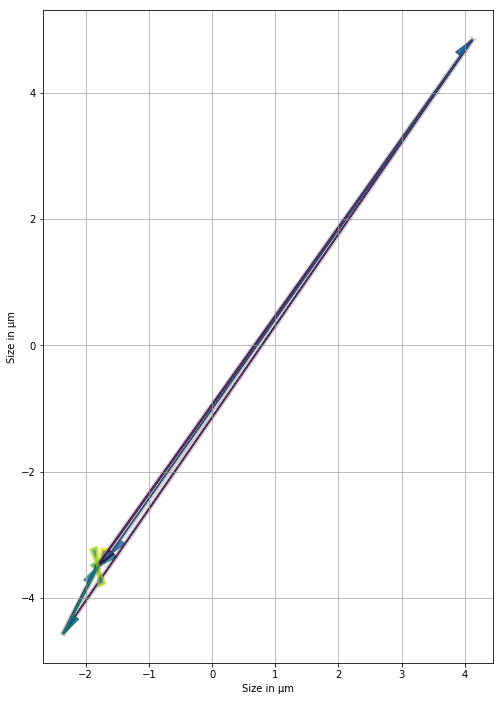

In [32]:
print_tensions(sym_organo, sym_organo)

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.2937701   0.         -0.61435908
   0.0641178 ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.          0.04266269  0.39007056  0.
  -0.08654665]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

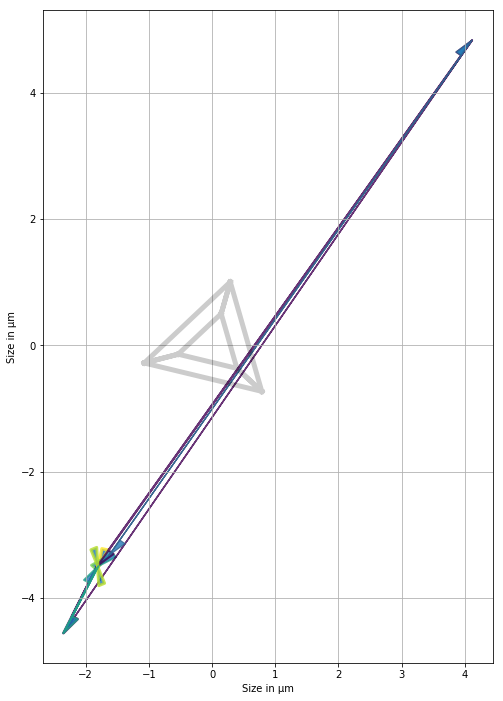

In [30]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='LINALG',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.2937701   0.         -0.61435908
   0.0641178 ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.          0.04266269  0.39007056  0.
  -0.08654665]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

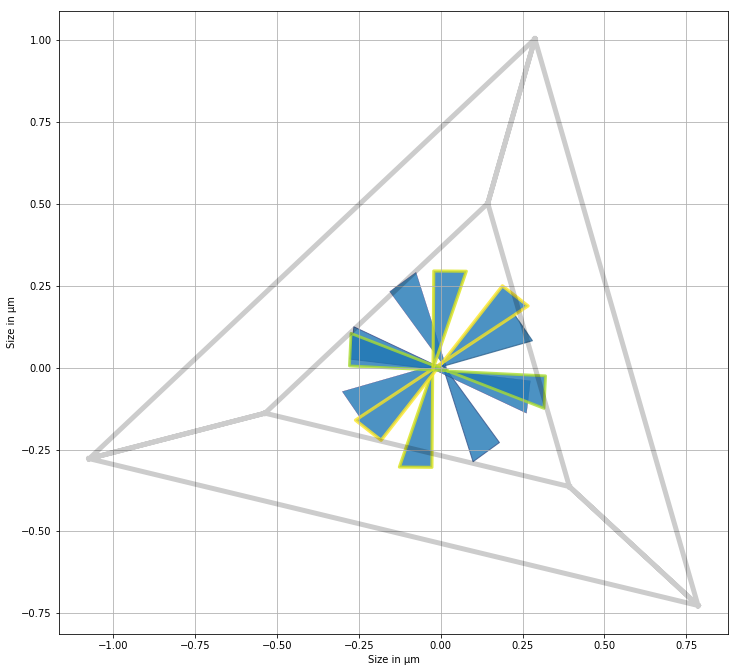

In [14]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

In [179]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, '')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

array([ 0, 12, 15])

In [ ]:
for ind, param in parameters:
    inds = vect_cut[]

In [97]:
grad_trgt[sym_organo.edge_df.loc[grad_trgt.index, 'trgt']==0]

,gx,gy
edge,,
2,-0.198996,-0.129410
6,0.174921,0.446997


In [102]:
grad_srce[sym_organo.edge_df.loc[grad_trgt.index, 'srce']==0]

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705


In [101]:
sym_organo.edge_df.loc[grad_srce[sym_organo.edge_df.loc[grad_trgt.index, 'srce']==0].index, :]

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,fx,fy,segment,prev,sub_area,ux,uy,uz,line_tension,is_active
edge,,,,,,,,,,,,,,,,,,,,,
0,1,0.124827,0.956624,0,0,-0.929960,0.224289,0.393047,-0.363252,-0.536912,...,-0.107899,-0.376661,apical,6,0.062413,0.0,0.0,0.0,0.2,1
11,3,0.187240,0.535199,2,0,0.393047,-0.363252,0.393047,-0.363252,0.786094,...,0.402684,0.104222,lateral,2,0.093620,0.0,0.0,0.0,0.1,1


In [138]:
grad_calc = sym_organo.copy()
grad_calc.vert_df.loc[3, 'x'] += 0.001
geom.update_all(grad_calc)
print((grad_calc.face_df.area[0]-sym_organo.face_df.area[0])/0.001)

-0.04266268773323034


In [37]:
sym_organo.edge_df.loc[:, ('srce', 'trgt')]

,srce,trgt
edge,,
0,0,1
1,1,2
2,2,0
3,4,3
4,5,4
5,3,5
6,3,0
7,4,1
8,5,2


In [38]:
sym_organo.edge_df.loc[grad_trgt.index, 'face']

edge
0     0
1     1
2     2
3     0
4     1
5     2
6     0
7     1
8     2
9     0
10    1
11    2
Name: face, dtype: int64

In [39]:
sym_organo.edge_df.loc[grad_trgt.index, 'srce']

edge
0     0
1     1
2     2
3     4
4     5
5     3
6     3
7     4
8     5
9     1
10    2
11    0
Name: srce, dtype: int64

In [40]:
grad_trgt[sym_organo.edge_df.loc[grad_trgt.index, 'face']==0]

,gx,gy
edge,,
0,-0.006705,0.250473
3,-0.049367,-0.482963
6,0.174921,0.446997
9,-0.118849,-0.214507


In [41]:
grad_srce[sym_organo.edge_df.loc[grad_srce.index, 'srce']==0]

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705


In [42]:
grad_srce[sym_organo.edge_df.loc[grad_srce.index, 'srce']==0]

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705


In [43]:
adj_0 = pd.concat((grad_srce[sym_organo.edge_df.loc[grad_srce.index, 'srce']==0],
                   grad_trgt[sym_organo.edge_df.loc[grad_srce.index, 'trgt']==0]))

In [44]:
mat = np.zeros((sym_organo.Nv, sym_organo.Nf))

In [45]:
adj_0

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705
2,-0.198996,-0.129410
6,0.174921,0.446997


In [46]:
grouped_srce.groups.keys()

NameError: name 'grouped_srce' is not defined

In [58]:
#%%timeit
#def _areas_coefs(sym_organo, no_scale):
vertex=0

grad_srce, grad_trgt = area_grad(sym_organo)
grad_lumen_srce, grad_lumen_trgt = lumen_area_grad(sym_organo)
grouped_srce = grad_srce.groupby(sym_organo.edge_df.srce)
grouped_trgt = grad_trgt.groupby(sym_organo.edge_df.trgt)
grouped_lumen_srce = grad_lumen_srce.groupby(sym_organo.edge_df.srce)
grouped_lumen_trgt = grad_lumen_trgt.groupby(sym_organo.edge_df.trgt)
area_coef = np.zeros((2*sym_organo.Nv, sym_organo.Nf+1))
for vertex in range(sym_organo.Nv):
    adj_srce = grouped_srce.get_group(list(grouped_srce.groups.keys())[vertex])
    adj_trgt = grouped_trgt.get_group(list(
        grouped_trgt.groups.keys())[vertex])[::-1]
    adj_lumen_srce = grouped_lumen_srce.get_group(list(
        grouped_lumen_srce.groups.keys())[vertex])
    adj_lumen_trgt = grouped_lumen_trgt.get_group(list(
        grouped_lumen_trgt.groups.keys())[vertex])[::-1]
    area_coef[vertex][sym_organo.edge_df.loc[
        adj_srce.index, 'face']] = adj_srce.gx.values + adj_trgt.gx.values
    area_coef[sym_organo.Nv+vertex][sym_organo.edge_df.loc[
        adj_srce.index, 'face']] = adj_srce.gy.values + adj_trgt.gy.values
    area_coef[vertex][sym_organo.Nf] = np.sum((adj_lumen_srce.gx,
                                               adj_lumen_trgt.gx))
    area_coef[sym_organo.Nv+vertex][sym_organo.Nf] = np.sum((adj_lumen_srce.gy,
                                                             adj_lumen_trgt.gy))

grad_factors = np.tile(sym_organo.face_df.area_elasticity, 2)

area_elasticity = np.tile(np.hstack([sym_organo.face_df.area_elasticity,
                                     sym_organo.settings['lumen_elasticity']]),
                          (2*sym_organo.Nv, 1))

area_coef *= area_elasticity
    
#    return area_coef

In [66]:
grouped_trgt.get_group(list(grouped_srce.groups.keys())[0])

,gx,gy
edge,,
2,-0.198996,-0.129410
6,0.174921,0.446997


In [65]:
grouped_srce.get_group(list(grouped_srce.groups.keys())[0]).index

Int64Index([0, 11], dtype='int64', name='edge')

In [81]:
sym_organo.edge_df.loc[grouped_srce.get_group(list(grouped_srce.groups.keys())[5]).index, ('srce', 'trgt', 'face')]

,srce,trgt,face
edge,,,
4,5,4,1
8,5,2,2


In [79]:
sym_organo.edge_df.loc[grouped_trgt.get_group(list(grouped_trgt.groups.keys())[5]).index, ('srce', 'trgt', 'face')]

,srce,trgt,face
edge,,,
5,3,5,2
10,2,5,1


In [351]:
#%%timeit
ind_dic = _indices_areas_coefs(sym_organo)  # coo_matrix indices
grad_srce, grad_trgt = area_grad(sym_organo)  # cell's areas gradient
grad_lumen_srce, grad_lumen_trgt = lumen_area_grad(sym_organo)  # lumen gradien
coef_shape = (sym_organo.apical_edges.shape[0], sym_organo.Nf+1)
coefs = _coefs_areas_coefs(sym_organo,
                           grad_srce, grad_trgt,
                           grad_lumen_srce, grad_lumen_trgt)
# print(coefs)
coef_x_apical = sparse.coo_matrix((coefs['api_x'],
                                   (ind_dic['api_cols'],
                                    ind_dic['api_rows'])),
                                  shape=(coef_shape))
coef_x_basal = sparse.coo_matrix((coefs['api_y'],
                                  (ind_dic['bas_cols'],
                                   ind_dic['bas_rows'])),
                                 shape=(coef_shape))
coef_y_apical = sparse.coo_matrix((coefs['bas_x'],
                                   (ind_dic['api_cols'],
                                    ind_dic['api_rows'])),
                                  shape=(coef_shape))
coef_y_basal = sparse.coo_matrix((coefs['bas_y'],
                                  (ind_dic['bas_cols'],
                                   ind_dic['bas_rows'])),
                                 shape=(coef_shape))
area_coefs = np.vstack((coef_x_apical.toarray(),
                        coef_x_basal.toarray(),
                        coef_y_apical.toarray(),
                        coef_y_basal.toarray()))

In [352]:
area_coefs

array([[-1.55962938,  0.        ,  3.11925876, -2.31089246],
       [ 8.91708573,  1.15544623,  0.        , -1.55962938],
       [ 0.        ,  1.15544623, -4.45854287, -4.45854287],
       [-2.93781692,  1.46890846,  0.        , -8.0262651 ],
       [ 0.        ,  2.15063125,  4.01313255,  1.46890846],
       [-1.07531563,  0.        ,  4.01313255, -1.07531563],
       [ 0.        ,  0.        ,  3.11925876, -2.31089246],
       [ 8.91708573,  0.        ,  0.        , -1.55962938],
       [ 0.        ,  1.15544623,  0.        , -4.45854287],
       [-2.93781692,  0.        ,  0.        , -8.0262651 ],
       [ 0.        ,  2.15063125,  0.        ,  1.46890846],
       [ 0.        ,  0.        ,  4.01313255, -1.07531563]])

In [375]:
sym_organo.edge_df.loc[:, ('srce', 'trgt', 'dx', 'length')]

,srce,trgt,dx,length
edge,,,,
0,0,1,-0.929960,0.956624
1,1,2,0.680778,0.935183
2,2,0,0.249182,0.900624
3,4,3,1.859919,1.913249
4,5,4,-1.361555,1.870366
5,3,5,-0.498364,1.801248
6,3,0,-0.393047,0.535199
7,4,1,0.536912,0.554604
8,5,2,-0.143865,0.522415


In [369]:
sym_organo.vert_df.loc[(0,1), :]

,y,is_active,x,segment,adhesion_strength,x_ecm,y_ecm
vert,,,,,,,
0,-0.363252,1,0.393047,apical,0.0,0.0,0.0
1,-0.138963,1,-0.536912,apical,0.0,0.0,0.0
